<a href="https://colab.research.google.com/github/suryanshshah2006/Brain-Tumor-detection/blob/main/Brain_Tumor_Classification_using_Dual_Stream_Shallow_CNN_without_Grayscaling_ipynb_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install -q kaggle

In [2]:
import json
import os

kaggle_username = 'suryanshshah'
kaggle_token = 'KGAT_c6e62e674ce15cae2dd30a93bf313757'

! mkdir -p ~/.kaggle
with open('kaggle.json', 'w') as f:
    json.dump({"username": kaggle_username, "key": kaggle_token}, f)

! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

print("Kaggle authentication successful!")

Kaggle authentication successful!


In [3]:
! kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 79% 118M/149M [00:00<00:00, 604MB/s] 
100% 149M/149M [00:00<00:00, 611MB/s]


In [4]:
! unzip brain-tumor-mri-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Training/glioma/Tr-gl_0712.jpg  
  inflating: Training/glioma/Tr-gl_0713.jpg  
  inflating: Training/glioma/Tr-gl_0714.jpg  
  inflating: Training/glioma/Tr-gl_0715.jpg  
  inflating: Training/glioma/Tr-gl_0716.jpg  
  inflating: Training/glioma/Tr-gl_0717.jpg  
  inflating: Training/glioma/Tr-gl_0718.jpg  
  inflating: Training/glioma/Tr-gl_0719.jpg  
  inflating: Training/glioma/Tr-gl_0720.jpg  
  inflating: Training/glioma/Tr-gl_0721.jpg  
  inflating: Training/glioma/Tr-gl_0722.jpg  
  inflating: Training/glioma/Tr-gl_0723.jpg  
  inflating: Training/glioma/Tr-gl_0724.jpg  
  inflating: Training/glioma/Tr-gl_0725.jpg  
  inflating: Training/glioma/Tr-gl_0726.jpg  
  inflating: Training/glioma/Tr-gl_0727.jpg  
  inflating: Training/glioma/Tr-gl_0728.jpg  
  inflating: Training/glioma/Tr-gl_0729.jpg  
  inflating: Training/glioma/Tr-gl_0730.jpg  
  inflating: Training/glioma/Tr-gl_0731.jpg  
  inflating: Training/glioma/

In [13]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

SEED = 123
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE

In [14]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/Training",
    validation_split=0.123,
    subset="training",
    seed=SEED,
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode="rgb",
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/Training",
    validation_split=0.123,
    subset="validation",
    seed=SEED,
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode="rgb",
    shuffle=True
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/Testing",
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode="rgb",
    shuffle=False
)

class_names = train_ds.class_names
print("classes:", class_names)

Found 5712 files belonging to 4 classes.
Using 5010 files for training.
Found 5712 files belonging to 4 classes.
Using 702 files for validation.
Found 1311 files belonging to 4 classes.
classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [7]:
class_names = train_ds.class_names
print("classes:", class_names)

classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [15]:
def gaussian_kernel(ksize=5, sigma=1.0, channels=3):
    ax = tf.range(-(ksize // 2), (ksize // 2) + 1, dtype=tf.float32)
    xx, yy = tf.meshgrid(ax, ax)
    kernel = tf.exp(-(xx**2 + yy**2) / (2.0 * sigma**2))
    kernel = kernel / tf.reduce_sum(kernel)
    kernel = kernel[:, :, tf.newaxis, tf.newaxis]
    return tf.repeat(kernel, repeats=channels, axis=2)

def gaussian_blur_tf(images, labels, ksize=5, sigma=1.0):
    x = tf.cast(images, tf.float32)
    x = tf.cond(tf.reduce_max(x) > 1.5, lambda: x/255.0, lambda: x)
    kernel = gaussian_kernel(ksize=ksize, sigma=sigma, channels=3)
    blurred = tf.nn.depthwise_conv2d(x, kernel, strides=[1,1,1,1], padding="SAME")
    return blurred, labels

In [17]:
def gaussian_blur_tf(images, labels, ksize=5, sigma=1.0):
    x = tf.cast(images, tf.float32)
    x = tf.cond(tf.reduce_max(x) > 1.5, lambda: x/255.0, lambda: x)
    kernel = gaussian_kernel(ksize=ksize, sigma=sigma, channels=3)
    blurred = tf.nn.depthwise_conv2d(x, kernel, strides=[1,1,1,1], padding="SAME")
    return blurred, labels

In [18]:
train_blur = train_ds.map(lambda x,y: gaussian_blur_tf(x,y), num_parallel_calls=AUTOTUNE)
val_blur = val_ds.map(lambda x,y: gaussian_blur_tf(x,y), num_parallel_calls=AUTOTUNE)
test_blur = test_ds.map(lambda x,y: gaussian_blur_tf(x,y), num_parallel_calls=AUTOTUNE)

In [19]:
def to_gray01(x_rgb):
    return tf.image.rgb_to_grayscale(x_rgb)

def threshold_paper_tf(images_rgb, labels, thr=45.0):
    g = to_gray01(images_rgb)
    thr01 = thr / 255.0
    mask01 = tf.where(g > thr01, 1.0, 0.0)
    return mask01, labels

def morph_paper_tf(mask01, labels, ksize=3, erode_iters=2, dilate_iters=1):
    x = tf.cast(mask01, tf.float32)
    kernel = tf.ones((ksize, ksize, 1), dtype=tf.float32)
    for _ in range(erode_iters):
        x = tf.nn.erosion2d(x, kernel, strides=[1,1,1,1], padding="SAME", data_format="NHWC", dilations=[1,1,1,1])
    for _ in range(dilate_iters):
        x = tf.nn.dilation2d(x, kernel, strides=[1,1,1,1], padding="SAME", data_format="NHWC", dilations=[1,1,1,1])
    x = tf.where(x > 0.5, 1.0, 0.0)
    return x, labels

In [20]:
train_mask = train_blur.map(lambda x,y: threshold_paper_tf(x,y), num_parallel_calls=AUTOTUNE)
val_mask = val_blur.map(lambda x,y: threshold_paper_tf(x,y), num_parallel_calls=AUTOTUNE)
test_mask = test_blur.map(lambda x,y: threshold_paper_tf(x,y), num_parallel_calls=AUTOTUNE)

train_mask_m = train_mask.map(lambda m,y: morph_paper_tf(m,y), num_parallel_calls=AUTOTUNE)
val_mask_m = val_mask.map(lambda m,y: morph_paper_tf(m,y), num_parallel_calls=AUTOTUNE)
test_mask_m = test_mask.map(lambda m,y: morph_paper_tf(m,y), num_parallel_calls=AUTOTUNE)

In [21]:
def to_gray01(x_rgb):
    return tf.image.rgb_to_grayscale(x_rgb)

def threshold_paper_tf(images_rgb, labels, thr=45.0):
    g = to_gray01(images_rgb)
    thr01 = thr / 255.0
    mask01 = tf.where(g > thr01, 1.0, 0.0)
    return mask01, labels

def morph_paper_tf(mask01, labels, ksize=3, erode_iters=2, dilate_iters=1):
    x = tf.cast(mask01, tf.float32)
    kernel = tf.ones((ksize, ksize, 1), dtype=tf.float32)
    for _ in range(erode_iters):
        x = tf.nn.erosion2d(x, kernel, strides=[1,1,1,1], padding="SAME", data_format="NHWC", dilations=[1,1,1,1])
    for _ in range(dilate_iters):
        x = tf.nn.dilation2d(x, kernel, strides=[1,1,1,1], padding="SAME", data_format="NHWC", dilations=[1,1,1,1])
    x = tf.where(x > 0.5, 1.0, 0.0)
    return x, labels

In [22]:
train_mask = train_blur.map(lambda x,y: threshold_paper_tf(x,y), num_parallel_calls=AUTOTUNE)
val_mask = val_blur.map(lambda x,y: threshold_paper_tf(x,y), num_parallel_calls=AUTOTUNE)
test_mask = test_blur.map(lambda x,y: threshold_paper_tf(x,y), num_parallel_calls=AUTOTUNE)

train_mask_m = train_mask.map(lambda m,y: morph_paper_tf(m,y), num_parallel_calls=AUTOTUNE)
val_mask_m = val_mask.map(lambda m,y: morph_paper_tf(m,y), num_parallel_calls=AUTOTUNE)
test_mask_m = test_mask.map(lambda m,y: morph_paper_tf(m,y), num_parallel_calls=AUTOTUNE)

In [23]:
def crop_by_mask_tf(blur_images_rgb, mask_images, labels, out_size=(224,224), pad=6):
    blur_images_rgb = tf.cast(blur_images_rgb, tf.float32)
    mask = tf.cast(mask_images > 0.5, tf.float32)
    H, W = tf.cast(tf.shape(mask)[1], tf.int64), tf.cast(tf.shape(mask)[2], tf.int64) # Cast H and W to int64
    def _crop_one(args):
        img, msk, lab = args
        m = tf.squeeze(msk, axis=-1)
        coords = tf.where(m > 0.0)
        def no_fg():
            return tf.image.resize(img, out_size), lab
        def has_fg():
            y_min, x_min = tf.reduce_min(coords[:,0]), tf.reduce_min(coords[:,1])
            y_max, x_max = tf.reduce_max(coords[:,0]), tf.reduce_max(coords[:,1])
            y_min_p, x_min_p = tf.maximum(y_min-pad, 0), tf.maximum(x_min-pad, 0)
            y_max_p, x_max_p = tf.minimum(y_max+pad, H-1), tf.minimum(x_max+pad, W-1)
            crop = img[y_min_p:y_max_p+1, x_min_p:x_max_p+1, :]
            return tf.image.resize(crop, out_size), lab
        return tf.cond(tf.shape(coords)[0] > 0, has_fg, no_fg)
    return tf.map_fn(_crop_one, (blur_images_rgb, mask, labels), fn_output_signature=(tf.float32, labels.dtype))

In [24]:
train_roi = tf.data.Dataset.zip((train_blur, train_mask_m)).map(lambda a,b: crop_by_mask_tf(a[0], b[0], a[1]), num_parallel_calls=AUTOTUNE)
val_roi = tf.data.Dataset.zip((val_blur, val_mask_m)).map(lambda a,b: crop_by_mask_tf(a[0], b[0], a[1]), num_parallel_calls=AUTOTUNE)
test_roi = tf.data.Dataset.zip((test_blur, test_mask_m)).map(lambda a,b: crop_by_mask_tf(a[0], b[0], a[1]), num_parallel_calls=AUTOTUNE)

In [25]:
def lbp_tf(images_rgb, labels):
    x = tf.cast(images_rgb, tf.float32)
    x = tf.cond(tf.reduce_max(x) > 1.5, lambda: x/255.0, lambda: x)
    g = tf.image.rgb_to_grayscale(x)
    gpad = tf.pad(g, [[0,0], [1,1], [1,1], [0,0]], mode="REFLECT")
    c = gpad[:, 1:-1, 1:-1, :]
    n0, n1, n2 = gpad[:, 0:-2, 0:-2, :], gpad[:, 0:-2, 1:-1, :], gpad[:, 0:-2, 2:, :]
    n3, n4, n5 = gpad[:, 1:-1, 2:, :], gpad[:, 2:, 2:, :], gpad[:, 2:, 1:-1, :]
    n6, n7 = gpad[:, 2:, 0:-2, :], gpad[:, 1:-1, 0:-2, :]
    lbp = (tf.cast(n0>=c, tf.float32)*1.0 + tf.cast(n1>=c, tf.float32)*2.0 + tf.cast(n2>=c, tf.float32)*4.0 +
           tf.cast(n3>=c, tf.float32)*8.0 + tf.cast(n4>=c, tf.float32)*16.0 + tf.cast(n5>=c, tf.float32)*32.0 +
           tf.cast(n6>=c, tf.float32)*64.0 + tf.cast(n7>=c, tf.float32)*128.0) / 255.0
    return lbp, labels

In [26]:
train_lbp = train_roi.map(lbp_tf, num_parallel_calls=AUTOTUNE)
val_lbp = val_roi.map(lbp_tf, num_parallel_calls=AUTOTUNE)
test_lbp = test_roi.map(lbp_tf, num_parallel_calls=AUTOTUNE)

In [27]:
def make_4ch(rgb_ds, lbp_ds):
    paired = tf.data.Dataset.zip((rgb_ds, lbp_ds))
    return paired.map(lambda a, b: (tf.concat([a[0], b[0]], axis=-1), a[1]), num_parallel_calls=AUTOTUNE)

In [28]:
train_ds_4ch = make_4ch(train_roi, train_lbp).cache().shuffle(512, seed=SEED).prefetch(AUTOTUNE)
val_ds_4ch = make_4ch(val_roi, val_lbp).cache().prefetch(AUTOTUNE)
test_ds_4ch = make_4ch(test_roi, test_lbp).cache().prefetch(AUTOTUNE)

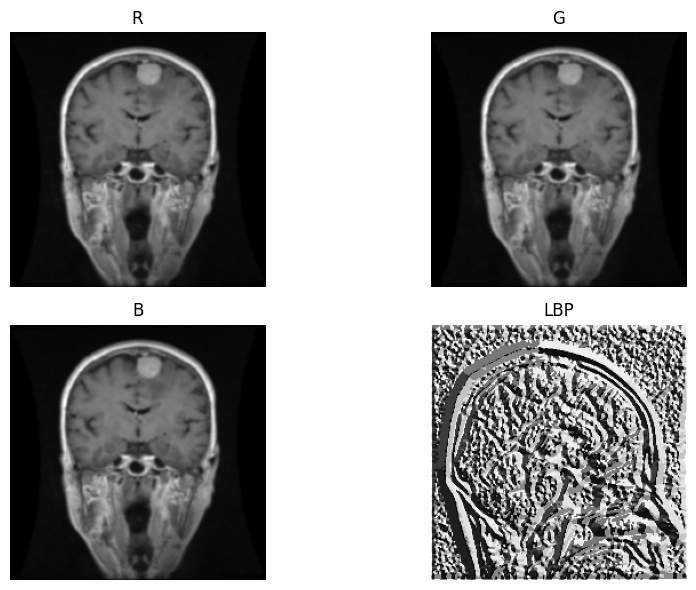

In [29]:
def show_one_4ch(ds):
    x, y = next(iter(ds))
    x = x[0].numpy()
    r, g, b, lbp = x[...,0], x[...,1], x[...,2], x[...,3]
    plt.figure(figsize=(10,6))
    plt.subplot(2,2,1); plt.imshow(r, cmap="gray"); plt.title("R"); plt.axis("off")
    plt.subplot(2,2,2); plt.imshow(g, cmap="gray"); plt.title("G"); plt.axis("off")
    plt.subplot(2,2,3); plt.imshow(b, cmap="gray"); plt.title("B"); plt.axis("off")
    plt.subplot(2,2,4); plt.imshow(lbp, cmap="gray"); plt.title("LBP"); plt.axis("off")
    plt.tight_layout(); plt.show()

show_one_4ch(train_ds_4ch)

In [34]:
class NovelAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.gap = tf.keras.layers.GlobalAveragePooling2D()
        self.relu = tf.keras.layers.Activation("relu")
        self.softmax = tf.keras.layers.Activation("softmax")
        self.mul = tf.keras.layers.Multiply()
    def build(self, input_shape):
        num_channels = int(input_shape[-1])
        self.dense = tf.keras.layers.Dense(num_channels)
        self.reshape = tf.keras.layers.Reshape((1, 1, num_channels))
        super().build(input_shape)
    def call(self, x):
        w = self.gap(x)
        w = self.dense(w)
        w = self.relu(w)
        w = self.softmax(w)
        w = self.reshape(w)
        return self.mul([x, w])


num_classes = 4
tf.keras.backend.clear_session()
inp = tf.keras.layers.Input(shape=(224,224,4))
rgb = tf.keras.layers.Lambda(lambda t: t[..., :3], name="rgb_split")(inp)
lbp = tf.keras.layers.Lambda(lambda t: t[..., 3:], name="lbp_split")(inp)

x1 = tf.keras.layers.Conv2D(32, (3,3), padding="same", activation="relu")(rgb)
x1 = tf.keras.layers.MaxPooling2D((2,2))(x1)
x1 = tf.keras.layers.Dropout(0.25)(x1)
x1 = tf.keras.layers.Conv2D(64, (3,3), padding="same", activation="relu")(x1)
x1 = tf.keras.layers.MaxPooling2D((2,2))(x1)

x2 = tf.keras.layers.Conv2D(32, (3,3), padding="same", activation="relu")(lbp)
x2 = tf.keras.layers.MaxPooling2D((2,2))(x2)
x2 = tf.keras.layers.Conv2D(64, (3,3), padding="same", activation="relu")(x2)
x2 = tf.keras.layers.MaxPooling2D((2,2))(x2)

x = tf.keras.layers.Concatenate(axis=-1)([x1, x2])
x = NovelAttention()(x)
x = tf.keras.layers.Conv2D(128, (3,3), padding="same", activation="relu")(x)
x = tf.keras.layers.MaxPooling2D((2,2))(x)
x = NovelAttention()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dropout(0.3)(x)
out = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

model = tf.keras.Model(inputs=inp, outputs=out, name="DualStream_ShallowMRI_Fusion")
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "DualStream_ShallowMRI_Fusion"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rgb_split (Lambda)  │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │        896 │ rgb_split[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lbp_split (Lambda)  │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 224, 224,  │        320 │ lbp_split[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 112, 112,  │          0 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 112, 112,  │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 112, 112,  │     18,496 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 112, 112,  │     18,496 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 56, 56,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 56, 56,    │          0 │ max_pooling2d_1[… │
│ (Concatenate)       │ 128)              │            │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ novel_attention     │ (None, 56, 56,    │     16,512 │ concatenate[0][0] │
│ (NovelAttention)    │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │    147,584 │ novel_attention[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 28, 28,    │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ novel_attention_1   │ (None, 28, 28,    │     16,512 │ max_pooling2d_4[

 Total params: 25,910,212 (98.84 MB)

 Trainable params: 25,910,212 (98.84 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
history = model.fit(train_ds_4ch, validation_data=val_ds_4ch, epochs=30)

Epoch 1/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 31s 78ms/step - accuracy: 0.4696 - loss: 1.1299 - val_accuracy: 0.7265 - val_loss: 0.6370
Epoch 2/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 18s 57ms/step - accuracy: 0.7455 - loss: 0.6477 - val_accuracy: 0.7906 - val_loss: 0.5443
Epoch 3/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 18s 57ms/step - accuracy: 0.7765 - loss: 0.5873 - val_accuracy: 0.8348 - val_loss: 0.4708
Epoch 4/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 18s 57ms/step - accuracy: 0.8186 - loss: 0.4894 - val_accuracy: 0.8262 - val_loss: 0.4417
Epoch 5/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 18s 57ms/step - accuracy: 0.8255 - loss: 0.4465 - val_accuracy: 0.8575 - val_loss: 0.3841
Epoch 6/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 18s 57ms/step - accuracy: 0.8591 - loss: 0.3872 - val_accuracy: 0.8519 - val_loss: 0.3639
Epoch 7/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 18s 57ms/step - accuracy: 0.8739 - loss: 0.3480 - val_accuracy: 0.8661 - val_loss: 0.3620
Epoch 8/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 18s 57ms/step - accuracy: 0.8797 - loss: 0.3111 - 

In [32]:
test_loss, test_acc = model.evaluate(test_ds_4ch)
print("Test accuracy:", test_acc)
print("Test loss:", test_loss)

82/82 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.9175 - loss: 0.4078
Test accuracy: 0.9405034184455872
Test loss: 0.30547431111335754


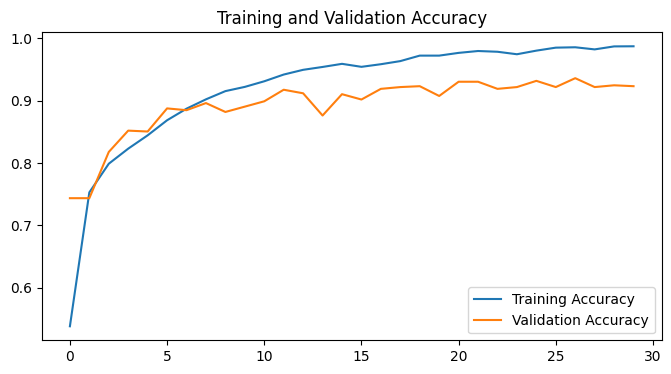

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs_range = range(len(acc))

plt.figure(figsize=(8, 4))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')
plt.show()